In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import os
import glob, cv2, time, math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Deep Neural Network with Dropout & L2 Regularization & ADAM Optimizer

In [2]:
def parameters_initialization(layers):
    
    """
    To Initialize Parameters in Deep Neural Network
    
    Arguments : 
    
        layers: How many layers in the DNN model
        
    Returns   :
    
        Parameters
    """
    np.random.seed(3)
    parameter = {}
    len_layers = len(layers)
    for l in range(1,len_layers):
        parameter["W"+str(l)] = np.random.randn(layers[l],layers[l-1])*np.sqrt(2/layers[l-1])
        parameter["b"+str(l)] = np.zeros((layers[l],1))
    return parameter

def initialize_adam(parameters) :
    
    """
    To Initialize Parameters v and s for ADAM Optimizer
    
    Arguments : 
    
        parameters : all parameters in model
        
    Returns   :
    
        v : ADAM Parameters
        s : ADAM Parameters
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
    
        v["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W"+str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b"+str(l)])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    To update all parameters in model
    
    Arguments : 
    
        parameters : all parameters in model
        grads : gradient of parameters
        v : ADAM parameters
        s : ADAM parameters
        t : Current layer
        learning_rate : learning rate
        beta1 : ADAM beta parameter 
        beta2 : ADAM beta parameter
        epsilon : epsilon
        
    Returns   :
    
        v : ADAM Parameters
        s : ADAM Parameters
    """
    
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW" + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db" + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)
        
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*(grads["dW" + str(l)])**2
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*(grads["db" + str(l)])**2

        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-beta2**t)

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*(v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)])+epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*(v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)])+epsilon))

    return parameters, v, s, v_corrected, s_corrected

def sigmoid(Z):
    
    """
    Activation Function where the value lies between (0,1) interval.
    
    Arguments :
    
        Z     : Linear value
        
    Returns   :
        
        val   : the output of Sigmoid function
        Z     : Linear value
        
    """
    val = 1./(1. + np.exp(-Z))
    return val, (val,Z)

def relu(Z):
    
    """
    Activation Function where the value lies between [0,inf) interval.
    
    Arguments :
    
        Z     : Linear value
        
    Returns   :
        
        val   : the output of Relu function
        Z     : Linear value
        
    """
    val = np.maximum(0.0,Z)
    return val, (val,Z)

def sigmoid_backward(AL, Y, cache):
    
    """
    To compute derivative of Sigmoid function
    
    Arguments :
    
        Al    : Linear value
        Y     : Actual prediction
        cahce : contains (Z)
        
    Returns   :
        
        dZ   : the output of derivative
    """
    Z = cache[1]
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    
    """
    To compute derivative of Sigmoid function
    
    Arguments :
    
        dA    : Previous value of dA
        cahce : contains (A, Z)
        
    Returns   :
        
        dZ  : the output of derivative
    """
    A = cache[0]
    Z = cache[1]
    dZ = np.multiply(dA, np.int64(A > 0))
    assert (dZ.shape == Z.shape)
    return  dZ

def back_prop_linear(dZ, caches):
    """
    To compute 
    
    Arguments :
    
        dA    : Previous value of dA
        cahce : contains (A, Z)
        
    Returns   :
        
        dZ  : the output of derivative
    """
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = 1./m * (np.dot(dZ, A_prev.T))
    db = 1./m * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def forward_prop_linear(A_prev, W, b):
    
    """"
    To compute linear function (Z)
    
    Arguments :
    
        A_prev   : Previous value of A
        W : W parameters
        b : b parameters
        
    Returns   :
        
        Z  : the output of lineas function
        caches : (A_prev, W, b)
    """
    Z = np.dot(W,A_prev) + b
    caches = (A_prev, W, b)
    return Z, caches

def forward_prop_activation(A_prev, W, b, activation):
    
    """"
    To compute Activation function 
    
    Arguments :
    
        A_prev   : Previous value of A
        W : W parameters
        b : b parameters
        activation : 'relu' or 'sigmoid'
        
    Returns   :
        
        A : the output of activation function
        caches : (linear caches, activation caches)
    """
    
    if activation == "sigmoid":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = relu(Z)
    caches = (linear_caches,activation_caches)
    return A , caches

def L_forward_prop(X, parameters):
    
    """"
    To compute prediction values
    
    Arguments :
    
        X : X values
        parameters : parameters
        
    Returns   :
        
        AL : prediction values
        caches : (linear caches, activation caches)
    """
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def L_forward_prop_dropout(X, parameters, keep_prob):
    
    """"
    To compute prediction values
    
    Arguments :
    
        X : X values
        parameters : parameters
        keep_prob : [0,1] values
        
    Returns   :
        
        AL : prediction values
        caches : (linear caches, activation caches)
    """
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        D = np.random.rand(A.shape[0],A.shape[1])
        D = (D <= keep_prob).astype('int64')
        A = np.multiply(A,D)/keep_prob
        cache = cache + (D,)
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches

def back_prop_linear_with_regularization(dZ, caches, lambd):
    
    """"
    To compute dA values
    
    Arguments :
    
        dZ : derivative of Z
        caches : (A_prev, W, b)
        lambd : Regularization value
        
    Returns   :
        
        dA_prev : derivative of A
        d_W : derivative of W
        d_b : derivative of b
    """
    
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = (1./m) * (np.dot(dZ, A_prev.T)) + (lambd/m)*W 
    db = (1./m) * np.sum(dZ,axis = 1, keepdims= True)
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def back_prop_activation_with_regularization_dropout(dA, Y, cache, lambd, activation):
    
    """"
    To compute dA values
    
    Arguments :
    
        dZ : derivative of Z
        caches : (A_prev, W, b)
        lambd : Regularization value
        
    Returns   :
        
        dA_prev : derivative of A
        d_W : derivative of W
        d_b : derivative of b
    """
    
    if activation == "sigmoid":
        linear_cache, activation_cache = cache
        dZ  = sigmoid_backward(dA, Y, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    elif activation == "relu":
        linear_cache, activation_cache, D = cache
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear_with_regularization(dZ, linear_cache, lambd)
        
    return dA_prev, dW, db

def L_back_prob_with_regularization_dropout(Y, AL, lambd, caches, keep_prob):
    
    """"
    To compute all parameters gradient
    
    Arguments :
    
        Y : Actual values
        Al : Prediction values
        lambd : Regularization value
        caches : (linear caches, activation caches)
        keep_prob : [0,1] values
        
    Returns   :
        
        grads : gradient of all parameters
    """
    
    
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    Y = Y.reshape(AL.shape)

    current_cache = caches[L-1]
    d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization_dropout(AL, Y, current_cache, lambd, activation = "sigmoid")
    grads["dA"+ str(L-1)] = d_A_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for i in  reversed(range(L-1)):
        current_cache = caches[i]
        grads["dA"+ str(i+1)] = np.multiply(grads["dA"+ str(i+1)], current_cache[-1])/keep_prob
        d_A_prev_temp, dW_temp, db_temp = back_prop_activation_with_regularization_dropout(grads["dA"+ str(i+1)],Y, current_cache, lambd, activation = "relu")
        grads["dA"+ str(i)] = d_A_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp
        
    return grads

def compute_cost_with_regularization(AL, Y, parameters,  lambd):
    
    """"
    To compute cost
    
    Arguments :
    
        Y : Actual values
        Al : Prediction values
        parameters : parameters
        lambd : Regularization value
        
    Returns   :
        
        cost :cost
    """
    
    
    m = Y.shape[1]
    n_params = len(parameters) // 2
    cost_original = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))
    L2_sum = 0
    
    for l in range(1, n_params + 1):
        L2_sum += np.sum(np.square(parameters["W" + str(l)]))
        
    L2_cost = (lambd/(2.*m))*L2_sum
    
    cost = cost_original + L2_cost
    return cost


def L_layer_model_with_regularization_adam(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0075, lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_iterations = 3000, keep_prob = 1,  print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X : data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y : true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims : list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate : learning rate of the gradient descent update rule
    num_iterations : number of iterations of the optimization loop
    keep_prob : [0,1] value
    print_cost : if True, it prints the cost every 100 steps
    
    Returns:
    parameters : parameters learnt by the model. They can then be used to predict.
    grads : gradient of model
    cost : cost of model
    train_acc : training accuracy
    test_acc : testing accuracy

    """

    np.random.seed(1)
    costs = []          # keep track of cost
    train_acc = []
    test_acc = []
    # Parameters initialization.
    parameters = parameters_initialization(layers_dims)
    v, s = initialize_adam(parameters)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_forward_prop_dropout(X_train, parameters, keep_prob)
        
        # Compute cost.
        cost = compute_cost_with_regularization(AL, Y_train, parameters,  lambd)
        costs.append(cost)
    
        # Backward propagation.
        grads = L_back_prob_with_regularization_dropout(Y_train, AL, lambd, caches, keep_prob)
 
        # Update parameters.
        parameters, v, s, v_corrected, s_corrected = update_parameters_with_adam(parameters, grads, v, s, i+1, learning_rate , beta1, beta2, epsilon)
        
        # Accuracy Checking.
        
        y_pred_train, caches_train = L_forward_prop(X_train, parameters)
        y_pred_test, caches_test = L_forward_prop(X_test, parameters)
        
        train_acc.append(accuracy_score(Y_train,y_pred_train))
        test_acc.append(accuracy_score(Y_test,y_pred_test))
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    return parameters, grads, costs, train_acc, test_acc

def plot_costs(costs, learning_rate=0.0075):
    
    """"
    To draw plot of cost
    
    Arguments :
        
        cost : cost
        learing_rate : learning rate
        
    Returns   :
        
        cost plot
    """
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
def accuracy_score(y_true, y_pred):
    """"
    To calculate an accuracy score
    
    Arguments :
        
        y_true : Actual value
        y_test : Prediction value
        
    Returns   :
        
        accuracy : accuracy
    """
    y_true = np.squeeze(y_true)
    y_pred = np.round(np.squeeze(y_pred)).astype("int64")
    m = len(y_pred)
    correct = len(y_pred[y_pred == y_true])
    accuracy = correct/m
    return accuracy

In [3]:
X, y = make_classification(n_samples = 10000, n_features = 15, n_informative = 10, n_redundant = 2, n_classes = 2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.05,  random_state = 42)

In [4]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
important_features = rf.feature_importances_
report = classification_report(y_test, y_pred)

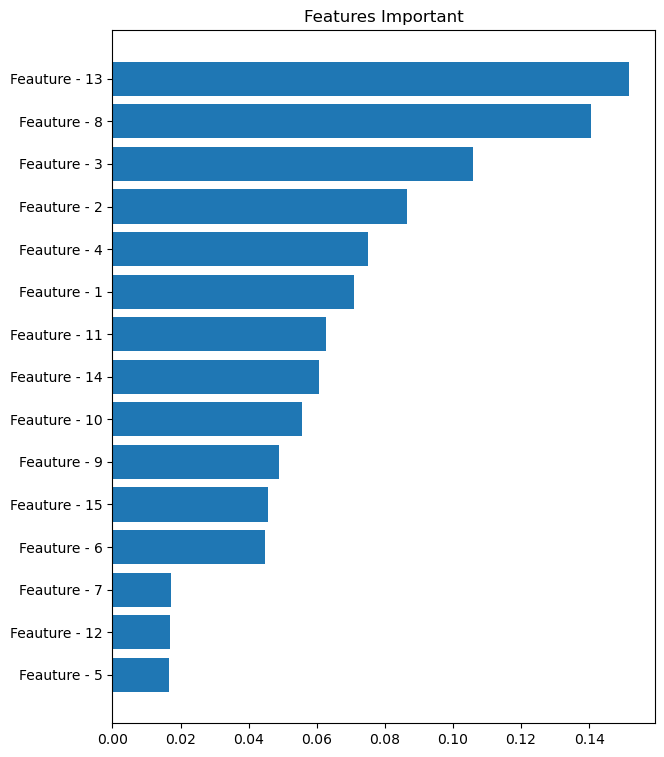

In [5]:
sorted_idx = np.argsort(important_features)
sorted_important_features = important_features[sorted_idx]
sorted_label_features = np.array([f"Feauture - {i}" for i in range(1,16)])[sorted_idx]

fig, ax = plt.subplots(figsize = (7,9))
ax.barh( y = np.arange(1,16) , width = sorted_important_features)
ax.set_yticks(np.arange(1,16))
ax.set_yticklabels(sorted_label_features)
ax.set_title("Features Important")
plt.show()

In [6]:
print("Classification report for Random Forest :")
print(report)

Classification report for Random Forest :
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       250
           1       0.92      0.93      0.93       250

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



In [8]:
X_train_tf = X_train.T
X_test_tf = X_test.T
y_train_tf = y_train.reshape(1,-1)
y_test_tf = y_test.reshape(1,-1)

print("Training Data Shape :")
print(f"X = {X_train_tf.shape}")
print(f"Y = {y_train_tf.shape}")
print("Testing Data Shape :")
print(f"X = {X_test_tf.shape}")
print(f"Y = {y_test_tf.shape}")

Training Data Shape :
X = (15, 9500)
Y = (1, 9500)
Testing Data Shape :
X = (15, 500)
Y = (1, 500)


In [9]:
layers = [15, 256, 256, 128, 128, 64, 64, 32, 32, 32, 1] # 10 layers
parameters, grads, costs, train_acc, test_acc =  L_layer_model_with_regularization_adam(X_train_tf, y_train_tf, X_test_tf, y_test_tf, layers, learning_rate = 0.00005, 
                                                                                        lambd = 0, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-7, num_iterations = 2000, keep_prob = .9,  print_cost = True)

Cost after iteration 0: 2.285945590790435
Cost after iteration 100: 0.7280137927869721
Cost after iteration 200: 0.5657679669557787
Cost after iteration 300: 0.4129637293951608
Cost after iteration 400: 0.33782525678365816
Cost after iteration 500: 0.2801400405450243
Cost after iteration 600: 0.25213465721088674


C:\Users\naufa\AppData\Local\Temp\ipykernel_2644\3541083182.py:420: RuntimeWarning: divide by zero encountered in log
  cost_original = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))
C:\Users\naufa\AppData\Local\Temp\ipykernel_2644\3541083182.py:420: RuntimeWarning: invalid value encountered in multiply
  cost_original = np.squeeze(-1./m * (np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1.-Y),np.log(1.-AL)))))


Cost after iteration 700: 0.21623046611435287
Cost after iteration 800: nan
Cost after iteration 900: 0.18151078667078696
Cost after iteration 1000: 0.16394380109788542
Cost after iteration 1100: 0.153563012445285
Cost after iteration 1200: 0.14801728086470886
Cost after iteration 1300: nan
Cost after iteration 1400: 0.13304182185459468
Cost after iteration 1500: 0.1293830900460066
Cost after iteration 1600: 0.12151432813826954
Cost after iteration 1700: nan
Cost after iteration 1800: 0.11449843224836014
Cost after iteration 1900: nan
Cost after iteration 1999: 0.10428424647738718


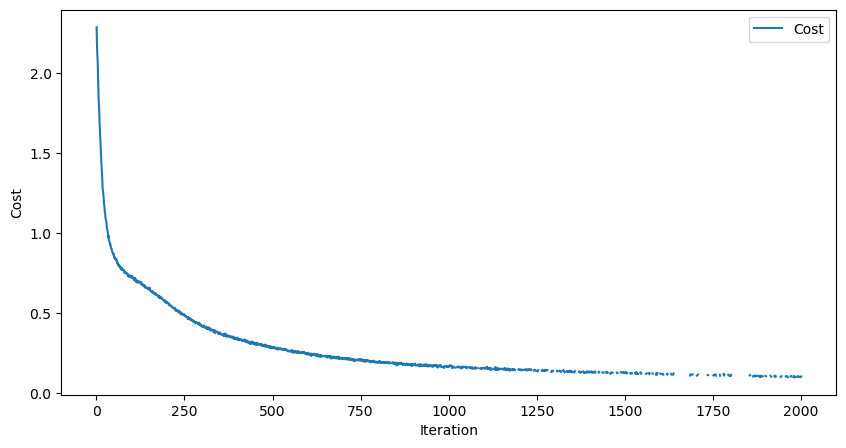

In [10]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(costs)+1), costs, label = 'Cost')
ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")
ax.legend()
plt.show()

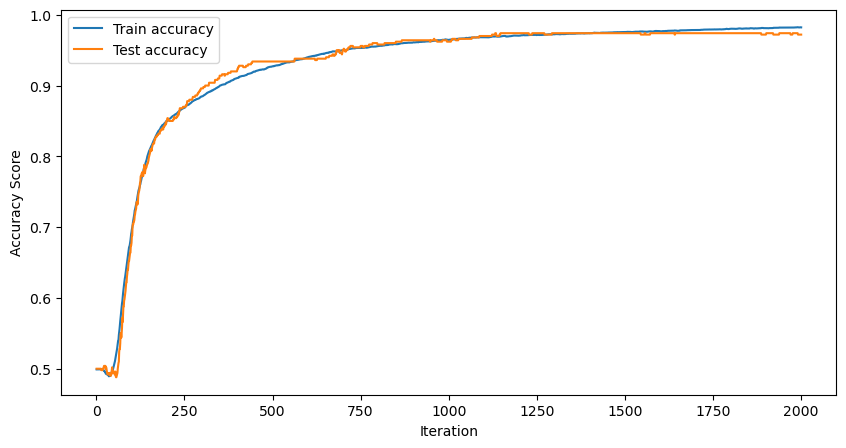

In [11]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1,len(train_acc)+1), train_acc, label = 'Train accuracy')
ax.plot(np.arange(1,len(test_acc)+1), test_acc, label = 'Test accuracy')
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy Score")
ax.legend()
plt.show()

In [12]:
y_pred , _ = L_forward_prop(X_test_tf, parameters)
y_pred = np.round(np.squeeze(y_pred)).astype(int)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       250
           1       0.96      0.98      0.97       250

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



## Image Recognition With CNN

In [19]:
training_dir = "C:/Users/naufa/Car-Bike-Dataset/Training"
validation_dir = "C:/Users/naufa/Car-Bike-Dataset/Validation"

training_gen = ImageDataGenerator(rescale = 1/255)
training_img = training_gen.flow_from_directory(directory  = training_dir, target_size = (224,224), batch_size = 50,
                                               class_mode = 'binary', shuffle = True)

validation_gen = ImageDataGenerator(rescale = 1/255)
validation_img = validation_gen.flow_from_directory(directory = validation_dir, target_size = (224,224), batch_size = 25,
                                                   class_mode = 'binary', shuffle = True)

Found 3700 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


##  CNN With Tensorflow

In [20]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [21]:
learning_rate = 0.001
epoch = 15
callbacks = MyCallBack()

## LeNet50 CNN Architecture 

In [24]:
model_1 = keras.Sequential([
    keras.layers.Conv2D(6, (5,5), activation = 'tanh', strides = 1, input_shape = (224,224,3)),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Conv2D(16, (5,5), activation = 'tanh', strides = 1),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'tanh'),
    keras.layers.Dense(84, activation = 'tanh'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model_1.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate), 
                loss = 'binary_crossentropy',
                metrics= ["accuracy"])
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 average_pooling2d_8 (Averag  (None, 110, 110, 6)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 average_pooling2d_9 (Averag  (None, 53, 53, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 44944)             0         
                                                                 
 dense_12 (Dense)            (None, 120)              

In [25]:
history = model_1.fit(x = training_img, epochs = epoch, callbacks = [callbacks], validation_data = validation_img)

Epoch 1/15
11/74 [===>..........................] - ETA: 29s - loss: 1.8952 - accuracy: 0.4800

C:\Users\naufa\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


74/74 [==============================] - 35s 474ms/step - loss: 0.9039 - accuracy: 0.4811 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 2/15
74/74 [==============================] - 27s 359ms/step - loss: 0.6968 - accuracy: 0.5178 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/15
74/74 [==============================] - 30s 399ms/step - loss: 0.6976 - accuracy: 0.4916 - val_loss: 0.6935 - val_accuracy: 0.5036
Epoch 4/15
74/74 [==============================] - 29s 395ms/step - loss: 0.6948 - accuracy: 0.4854 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 5/15
74/74 [==============================] - 29s 394ms/step - loss: 0.6923 - accuracy: 0.5127 - val_loss: 0.7188 - val_accuracy: 0.5000
Epoch 6/15
74/74 [==============================] - 29s 395ms/step - loss: 0.6897 - accuracy: 0.5232 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/15
74/74 [==============================] - 29s 395ms/step - loss: 0.6940 - accuracy: 0.5022 - val_loss: 0.6961 - val_accuracy: 0.4679
Epoch 8/15

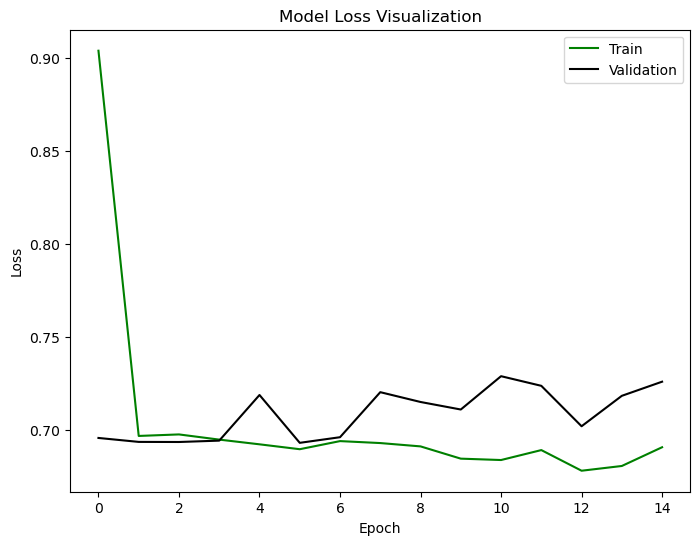

In [26]:
## Model loss Visualization
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

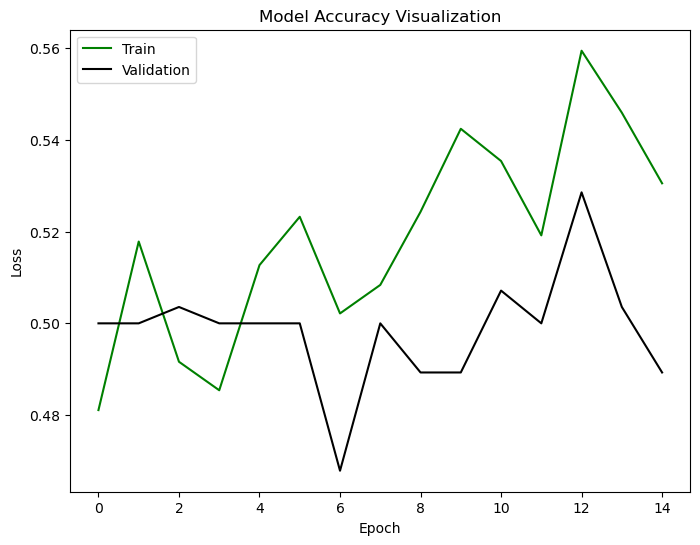

In [27]:
## Model Accuracy Visualization
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

## AlexNet CNN Architecture

In [28]:
model_2 = keras.Sequential([
    keras.layers.Conv2D(96, (11,11), strides = 4, activation = 'relu', input_shape = (224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(256, (5,5), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Conv2D(384, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.Conv2D(384, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.Conv2D(256, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    keras.layers.MaxPooling2D(3,3),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model_2.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy',
                metrics= ["accuracy"])
print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 96)       0         
 )                                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 18, 18, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 18, 18, 256)      1024      
 hNormalization)                                                 
                                                      

In [29]:
history = model_2.fit(x = training_img, epochs = epoch, validation_data = validation_img, callbacks = [callbacks])

Epoch 1/15
74/74 [==============================] - 38s 502ms/step - loss: 1.6571 - accuracy: 0.5970 - val_loss: 0.7069 - val_accuracy: 0.5250
Epoch 2/15
74/74 [==============================] - 40s 546ms/step - loss: 0.5928 - accuracy: 0.6932 - val_loss: 0.5266 - val_accuracy: 0.7214
Epoch 3/15
74/74 [==============================] - 42s 570ms/step - loss: 0.3650 - accuracy: 0.8524 - val_loss: 0.9185 - val_accuracy: 0.5214
Epoch 4/15
74/74 [==============================] - 41s 559ms/step - loss: 0.2524 - accuracy: 0.8989 - val_loss: 0.4096 - val_accuracy: 0.8107
Epoch 5/15
74/74 [==============================] - 41s 548ms/step - loss: 0.2097 - accuracy: 0.9208 - val_loss: 0.5176 - val_accuracy: 0.8179
Epoch 6/15
74/74 [==============================] - 40s 545ms/step - loss: 0.1790 - accuracy: 0.9303 - val_loss: 0.2308 - val_accuracy: 0.9107
Epoch 7/15
74/74 [==============================] - 40s 539ms/step - loss: 0.1494 - accuracy: 0.9443 - val_loss: 0.2532 - val_accuracy: 0.9286

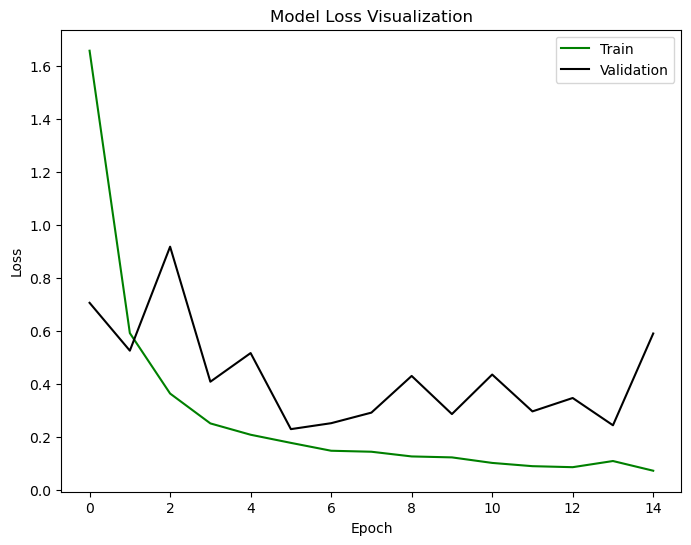

In [30]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

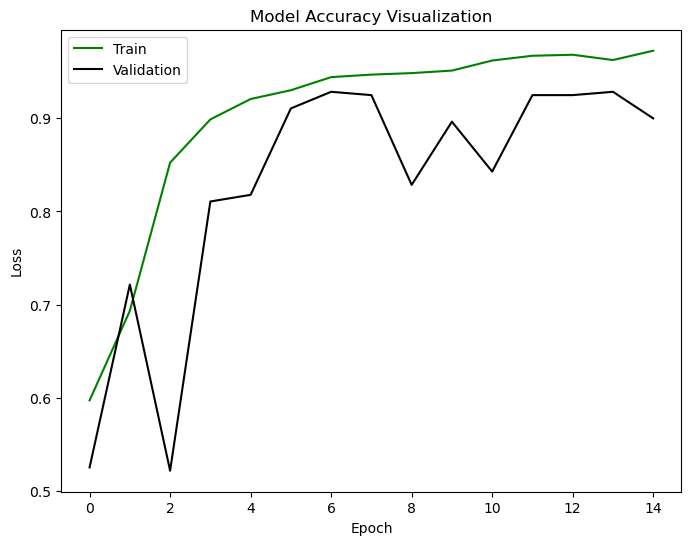

In [31]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

## Transfer Learning With ResNet50 & inception_v3

In [33]:
model_3 = tf.keras.Sequential()
base_model = ResNet50(include_top = False, weights = 'imagenet', pooling = "max", input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False
model_3.add(base_model)
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(512, activation = 'relu'))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [34]:
print(model_3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               65664     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 24,702,593
Trainable params: 1,114,881
N

In [35]:
model_3.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy',
                metrics = 'accuracy')

In [36]:
history = model_3.fit(x = training_img, validation_data = validation_img, epochs = epoch,
                     callbacks = [callbacks])

Epoch 1/15
74/74 [==============================] - 100s 1s/step - loss: 0.6911 - accuracy: 0.6968 - val_loss: 0.4100 - val_accuracy: 0.7929
Epoch 2/15
74/74 [==============================] - 101s 1s/step - loss: 0.4265 - accuracy: 0.8051 - val_loss: 0.3736 - val_accuracy: 0.8393
Epoch 3/15
74/74 [==============================] - 102s 1s/step - loss: 0.3941 - accuracy: 0.8205 - val_loss: 0.3305 - val_accuracy: 0.8321
Epoch 4/15
74/74 [==============================] - 101s 1s/step - loss: 0.3679 - accuracy: 0.8381 - val_loss: 0.2947 - val_accuracy: 0.8679
Epoch 5/15
74/74 [==============================] - 101s 1s/step - loss: 0.3730 - accuracy: 0.8384 - val_loss: 0.3156 - val_accuracy: 0.8714
Epoch 6/15
74/74 [==============================] - 101s 1s/step - loss: 0.3485 - accuracy: 0.8508 - val_loss: 0.3087 - val_accuracy: 0.8571
Epoch 7/15
74/74 [==============================] - 102s 1s/step - loss: 0.3474 - accuracy: 0.8492 - val_loss: 0.3011 - val_accuracy: 0.8679
Epoch 8/15
74

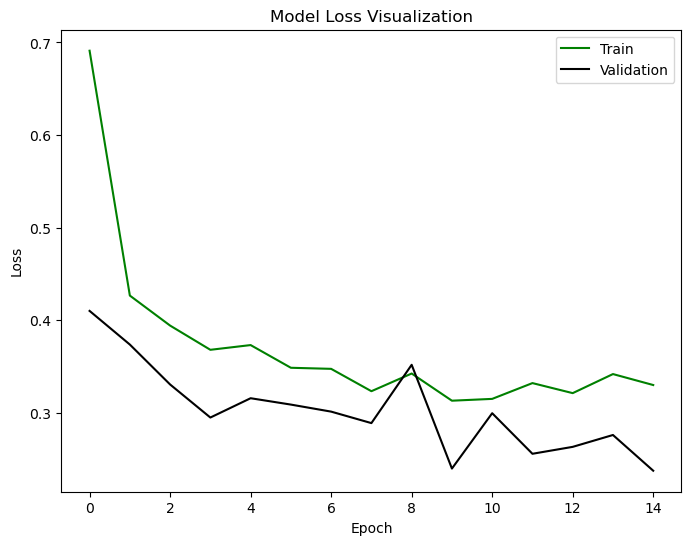

In [37]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

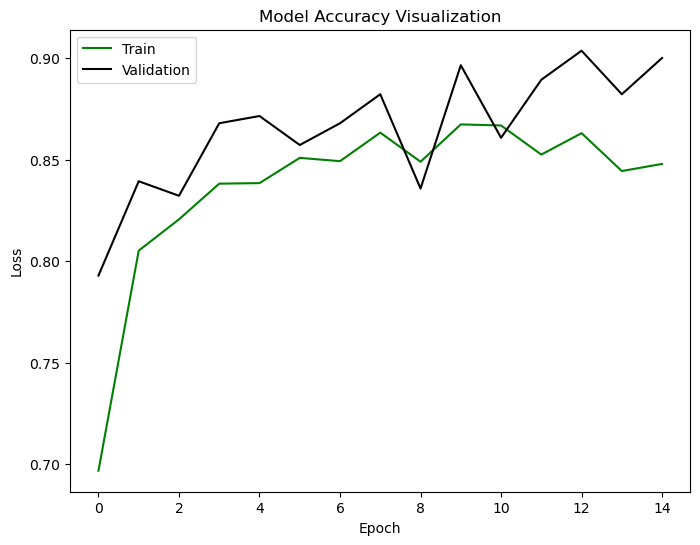

In [38]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [39]:
pre_trained_model = InceptionV3(include_top = False, input_shape = (224,224,3), weights = 'imagenet', pooling = 'avg')
for layer in pre_trained_model.layers:
    layer.trainable = False

In [40]:
print(pre_trained_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 111, 111, 32  96         ['conv2d_15[0][0]']              
 rmalization)                   )                                                      

 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_20[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_12 (BatchN  (None, 25, 25, 96)  288         ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_13 (BatchN  (None, 25, 25, 32)  96          ['conv2d_26[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_24 (BatchN  (None, 25, 25, 64)  192         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_38 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_49 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 12, 12, 128)  384        ['conv2d_49[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_46 (BatchN  (None, 12, 12, 160)  480        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_46[0][0]'] 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (None, 12, 12, 160)  480        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_57[0][0]'] 
          

                                                                                                  
 batch_normalization_67 (BatchN  (None, 12, 12, 192)  576        ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_81 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_89 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_72 (BatchN  (None, 12, 12, 192)  576        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 12, 12, 192)  576        ['conv2d_89[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_78 (BatchN  (None, 5, 5, 320)   960         ['conv2d_91[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_80[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_81[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_85[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 5, 5, 192)   576         ['conv2d_108[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 mixed9_1 

In [45]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
layer_ = tf.keras.layers.Flatten()(last_output)
layer_ = tf.keras.layers.Dense(512, activation = 'relu')(layer_)
layer_ = tf.keras.layers.Dense(256, activation = 'relu')(layer_)
layer_ = tf.keras.layers.Dropout(0.5)(layer_)
layer_ = tf.keras.layers.Dense(1, activation = 'sigmoid')(layer_)

model_4 = tf.keras.Model(pre_trained_model.input, layer_)
print(model_4.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 111, 111, 32  96         ['conv2d_15[0][0]']              
 rmalization)                   )                                                           

 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_20[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_12 (BatchN  (None, 25, 25, 96)  288         ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_13 (BatchN  (None, 25, 25, 32)  96          ['conv2d_26[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_24 (BatchN  (None, 25, 25, 64)  192         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_38 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_49 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 12, 12, 128)  384        ['conv2d_49[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_46 (BatchN  (None, 12, 12, 160)  480        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_46[0][0]'] 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (None, 12, 12, 160)  480        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_57[0][0]'] 
          

                                                                                                  
 batch_normalization_67 (BatchN  (None, 12, 12, 192)  576        ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_81 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

None


In [46]:
model_4.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', 
                metrics = 'accuracy')

In [47]:
history = model_4.fit(x = training_img, validation_data = validation_img, epochs = epoch, callbacks = [callbacks])

Epoch 1/15
74/74 [==============================] - 59s 776ms/step - loss: 0.2481 - accuracy: 0.9732 - val_loss: 0.0029 - val_accuracy: 0.9964
Epoch 2/15
74/74 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9943
Reached 99.9% accuracy so cancelling training!
74/74 [==============================] - 60s 809ms/step - loss: 0.0428 - accuracy: 0.9943 - val_loss: 0.1621 - val_accuracy: 0.9821


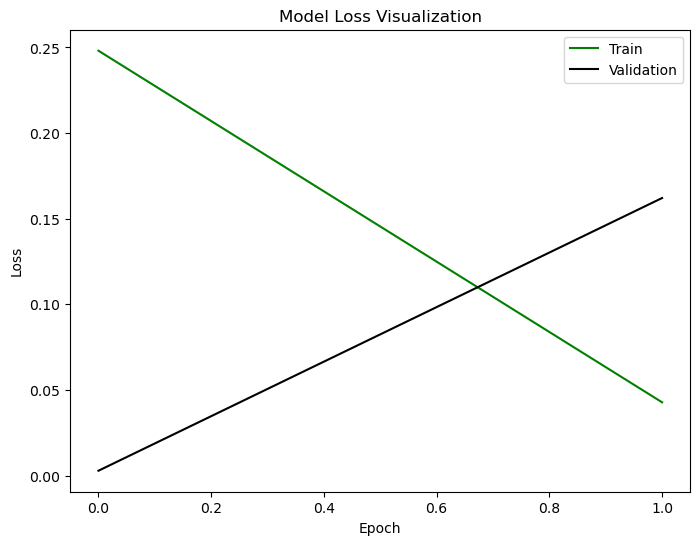

In [48]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(history.history['loss'], color = 'green',label = 'Train')
ax.plot(history.history['val_loss'], color = 'black', label = 'Validation')
ax.set_title("Model Loss Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

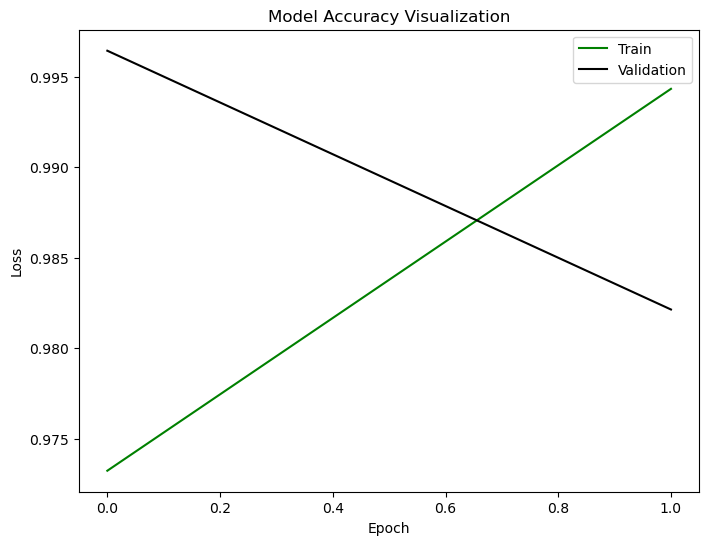

In [49]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(history.history['accuracy'], color = 'green',label = 'Train')
ax.plot(history.history['val_accuracy'], color = 'black', label = 'Validation')
ax.set_title("Model Accuracy Visualization")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [53]:
from tensorflow.keras.utils import load_img, img_to_array

In [97]:
img_batch = []
labels = []
for c in ["Car","Bike"]:
    list_img = os.listdir(f"C:/Users/naufa/Car-Bike-Dataset/Training/{c}")[10:20]
    for i in list_img:
        img = load_img(f"C:/Users/naufa/Car-Bike-Dataset/Training/{c}/{i}", target_size = (224,224,3))
        img_batch.append(img_to_array(img))
        labels.append(c)
img_batch = np.array(img_batch).astype(int)
labels = np.array(labels)
print(img_batch.shape)
print(labels.shape)

(20, 224, 224, 3)
(20,)


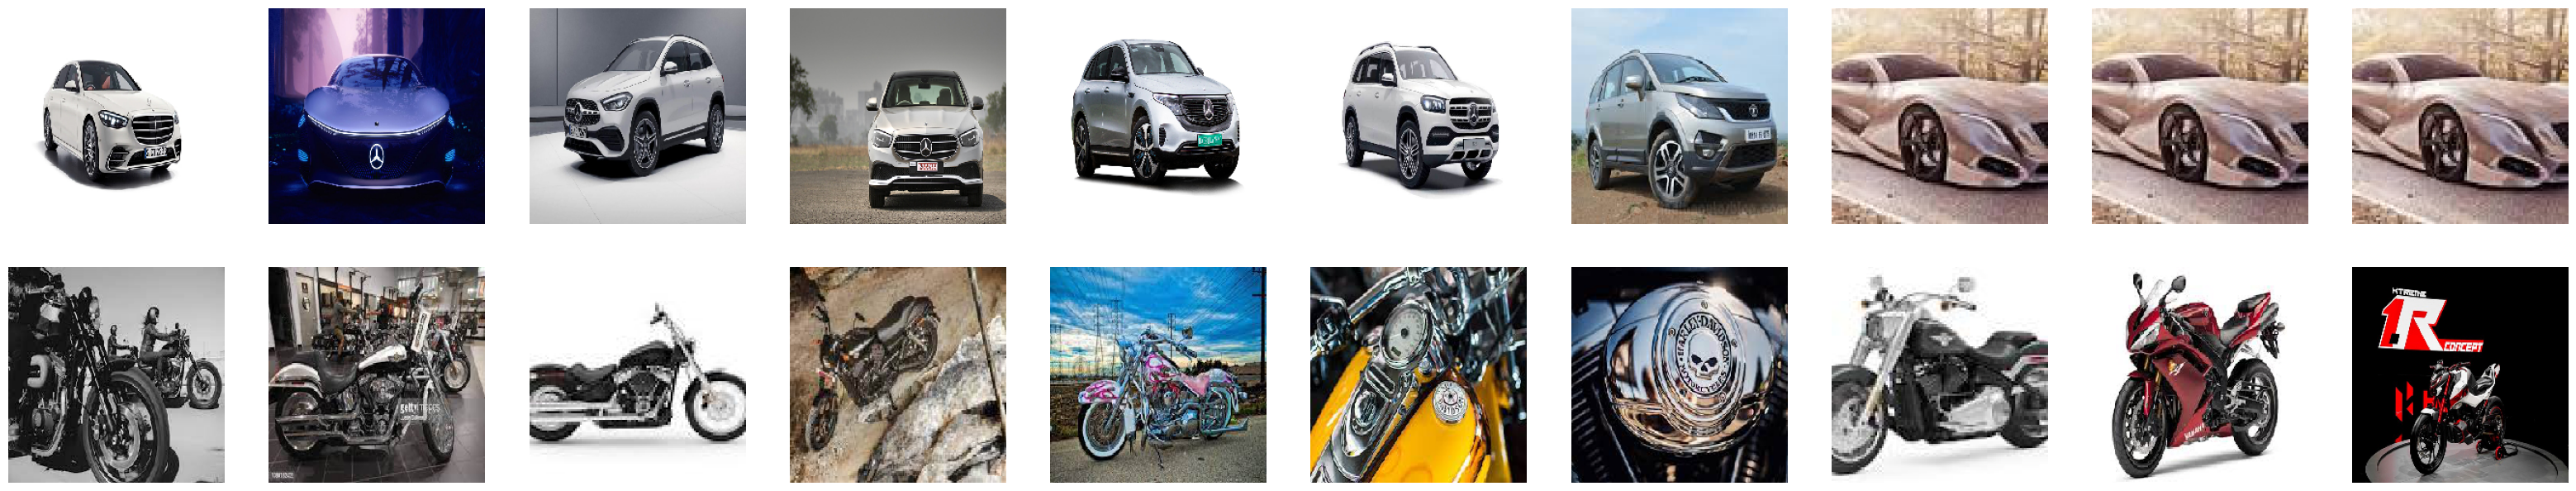

In [98]:
ncols = 10
nrows = 10

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
for i, img in enumerate(img_batch):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(10, 10, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(img)

In [99]:
pred = model_4.predict(img_batch)

1/1 [==============================] - 0s 259ms/step


In [100]:
print(np.round(pred))

[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
